In [1]:
import netCDF4
import pandas
import datetime
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import signal, ndimage
%matplotlib inline

In [2]:
minCutoffFitLat = 45.
delTimeCutOffNrstPass = 45 # min
mlonDiffOtrEndCutoff = 50.
delLatCutoff = 2.
delCtimeCutoff = 60. #min
gauss_smooth_sigma = 5. # Roughly corresponds to 1 deg in MLAT
diffElctrCutoffBnd = 0.1
filtEleFluxCutoffMagn = 1.25 # More than an order of magnitude, remember its a log scale

In [3]:
fileList = [ "../poes_n15_20130302_proc.nc",\
                "../poes_n18_20130302_proc.nc",\
                "../poes_m01_20130302_proc.nc",\
                "../poes_n19_20130302_proc.nc",\
                "../poes_m01_20130302_proc.nc",\
                "../poes_n16_20130302_proc.nc",\
                "../poes_n17_20130302_proc.nc" ]
poesAllEleDataDF = pandas.DataFrame( columns =  ["timestamp", "date", "aacgm_lat_foot",\
                         "aacgm_lon_foot", "MLT", "log_ele_flux", "sat"] )
poesAllProDataDF = pandas.DataFrame( columns =  ["timestamp", "date", "aacgm_lat_foot",\
                         "aacgm_lon_foot", "MLT", "log_pro_flux", "sat"] )
for f in fileList:
    print "reading file-->", f
    # read variable from the netCDF files
    poesRawData = netCDF4.Dataset(f)
    poesDF = pandas.DataFrame( poesRawData.variables['time'][:], columns=[ "timestamp" ] )
    poesDF['date'] = pandas.to_datetime(poesDF['timestamp'], unit='ms')
    poesDF["alt"] = poesRawData.variables['alt'][:]
    poesDF["aacgm_lat_foot"] = poesRawData.variables['aacgm_lat_foot'][:]

    poesDF["aacgm_lon_foot"] = poesRawData.variables['aacgm_lon_foot'][:]
    poesDF["MLT"] = poesRawData.variables['MLT'][:]
    # round of to 2 decimals
    poesDF['alt'] = [ round( x, 2 ) for x in poesDF['alt']]
    poesDF['aacgm_lat_foot'] = [ round( x, 2 ) for x in poesDF['aacgm_lat_foot']]
    poesDF['aacgm_lon_foot'] = [ round( x, 2 ) for x in poesDF['aacgm_lon_foot']]
    poesDF['MLT'] = [ round( x, 2 ) for x in poesDF['MLT']]
    # Add up the fluxes
    poesDF["ted_ele_total_flux"] = poesRawData.variables['ted_ele_tel0_flux_4'][:] +\
            poesRawData.variables['ted_ele_tel0_flux_8'][:] + \
            poesRawData.variables['ted_ele_tel0_flux_11'][:] + \
            poesRawData.variables['ted_ele_tel0_flux_14'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_4'][:] +\
            poesRawData.variables['ted_ele_tel30_flux_8'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_11'][:] + \
            poesRawData.variables['ted_ele_tel30_flux_14'][:]
    poesDF["ted_pro_total_flux"] = poesRawData.variables['ted_pro_tel0_flux_4'][:] +\
            poesRawData.variables['ted_pro_tel0_flux_8'][:] + \
            poesRawData.variables['ted_pro_tel0_flux_11'][:] + \
            poesRawData.variables['ted_pro_tel0_flux_14'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_4'][:] +\
            poesRawData.variables['ted_pro_tel30_flux_8'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_11'][:] + \
            poesRawData.variables['ted_pro_tel30_flux_14'][:]
    poesDF['log_ele_flux'] = [0. if x <= 0. else round( numpy.log10(x), 2 )\
                 for x in poesDF['ted_ele_total_flux']]
    poesDF['log_pro_flux'] = [0. if x <= 0. else round( numpy.log10(x), 2 )\
                 for x in poesDF['ted_pro_total_flux']]
    # the current satellite number
    poesDF["sat"] = f[-19:-17]
#     seperate out electron and proton flux and discard all zeros
    currPoesEleFluxDF = poesDF[poesDF["log_ele_flux"] > 0.][ ["timestamp",\
                     "date", "aacgm_lat_foot", "aacgm_lon_foot", "MLT",\
                     "log_ele_flux", "sat"] ].reset_index(drop=True)
    currPoesProFluxDF = poesDF[poesDF["log_pro_flux"] > 0.][ ["timestamp",\
                     "date", "aacgm_lat_foot", "aacgm_lon_foot", "MLT",\
                     "log_pro_flux", "sat"] ].reset_index(drop=True)
    
    
    poesAllEleDataDF = poesAllEleDataDF.append( currPoesEleFluxDF )
    poesAllProDataDF = poesAllProDataDF.append( currPoesProFluxDF )
    # now delete all the rows for prev DFs
    # we don't want to duplicate data
    poesDF = poesDF.drop( poesDF.index )
    currPoesEleFluxDF = currPoesEleFluxDF.drop( currPoesEleFluxDF.index )
    currPoesProFluxDF = currPoesProFluxDF.drop( currPoesProFluxDF.index )
# create a date and time columns
poesAllEleDataDF["dateStr"] = poesAllEleDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
poesAllEleDataDF["time"] = poesAllEleDataDF["date"].map(lambda x: x.strftime('%H%M'))
poesAllProDataDF["dateStr"] = poesAllProDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
poesAllProDataDF["time"] = poesAllProDataDF["date"].map(lambda x: x.strftime('%H%M'))

reading file--> ../poes_n15_20130302_proc.nc
reading file--> ../poes_n18_20130302_proc.nc
reading file--> ../poes_m01_20130302_proc.nc
reading file--> ../poes_n19_20130302_proc.nc
reading file--> ../poes_m01_20130302_proc.nc
reading file--> ../poes_n16_20130302_proc.nc
reading file--> ../poes_n17_20130302_proc.nc


In [4]:
#   sat              start_time                end_time
# 0  01 2013-03-02 03:26:54.755 2013-03-02 03:55:02.752
# 1  16 2013-03-02 04:28:24.986 2013-03-02 04:55:20.987
# 2  17 2013-03-02 03:56:16.193 2013-03-02 04:21:50.193
# 3  18 2013-03-02 03:10:09.132 2013-03-02 03:31:43.132
# 4  19 2013-03-02 04:42:44.994 2013-03-02 05:08:46.993

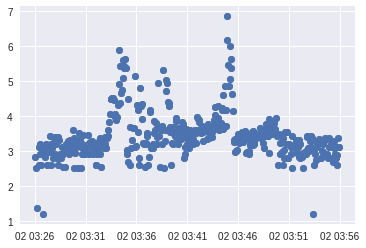

In [5]:
selSat = "01"
selStTime = datetime.datetime( 2013,3,2,3,26 )
selEndTime = datetime.datetime( 2013,3,2,3,56 )
testDF = poesAllEleDataDF[ (poesAllEleDataDF["sat"] == selSat) &\
                         (poesAllEleDataDF["date"] >= selStTime) &\
                         (poesAllEleDataDF["date"] <= selEndTime)].reset_index(drop=True)
testProDF = poesAllProDataDF[ (poesAllProDataDF["sat"] == selSat) &\
                         (poesAllProDataDF["date"] >= selStTime) &\
                         (poesAllProDataDF["date"] <= selEndTime)].reset_index(drop=True)
# plt.plot_date( testDF["date"], testDF["log_ele_flux"] )
plt.plot_date( testDF["date"], testDF["log_ele_flux"] )

In [6]:
# Divide satellite data to two passes
# we'll get boundary data from each pass
# In the first pass, sat is moving from 
# low to high latitudes and in the second one
# We'll get the opposite case
testDF = testDF.sort_values( ["sat","date"],\
                ascending=[True, True] \
                ).reset_index(drop=True)
# We'll get the the satellite pass which is moving polewards
# Basically percent change in latitudes should be positive
# for a satellite moving polewards.
testDF["latRowDiffs"] = testDF.groupby("sat")[[\
                "aacgm_lat_foot" ] ].pct_change()
testDFPolewards = testDF[\
                        testDF["latRowDiffs"] > 0.\
                        ].reset_index(drop=True)
testDFEquatorwards = testDF[\
                        testDF["latRowDiffs"] < 0.\
                        ].reset_index(drop=True)
# print testDFPolewards[ ["date", "aacgm_lat_foot", "MLT", "latRowDiffs", "log_ele_flux"] ]


In [7]:
# Get laplacian of gaussian for poleward pass
testDFPolewards["filtEleFluxPoleArr"] = ndimage.filters.gaussian_filter1d(testDFPolewards["log_ele_flux"],gauss_smooth_sigma) #
testDFPolewards["diffEleFluxPoleArr"] = numpy.gradient(numpy.gradient(testDFPolewards["filtEleFluxPoleArr"]))
# Get laplacian of gaussian for Equatorward pass
testDFEquatorwards["filtEleFluxEquatorArr"] = ndimage.filters.gaussian_filter1d(testDFEquatorwards["log_ele_flux"],gauss_smooth_sigma) #
testDFEquatorwards["diffEleFluxEquatorArr"] = numpy.gradient(numpy.gradient(testDFEquatorwards["filtEleFluxEquatorArr"]))
# Now get the max and min indices (of 
# Laplacian of Gaussian of electron flux) 
# for poleward and equatorward passes
# Poleward
minPolePassLoc = testDFPolewards[ \
                        testDFPolewards["diffEleFluxPoleArr"]\
                        == testDFPolewards["diffEleFluxPoleArr"].min() ]
minPolePassLoc = min( minPolePassLoc.index.values )
maxPolePassLoc = testDFPolewards[ \
                        testDFPolewards["diffEleFluxPoleArr"]\
                        == testDFPolewards["diffEleFluxPoleArr"].max() ]
maxPolePassLoc = min( maxPolePassLoc.index.values )
# # Equatorward
minEquatorPassLoc = testDFEquatorwards[ \
                        testDFEquatorwards["diffEleFluxEquatorArr"]\
                        == testDFEquatorwards["diffEleFluxEquatorArr"].min() ]
minEquatorPassLoc = max( minEquatorPassLoc.index.values )
maxEquatorPassLoc = testDFEquatorwards[ \
                        testDFEquatorwards["diffEleFluxEquatorArr"]\
                        == testDFEquatorwards["diffEleFluxEquatorArr"].max() ]
maxEquatorPassLoc = max( maxEquatorPassLoc.index.values )
# Now we calculate the equatorward boundary currently
# We'll only choose the sharpest edge (could be poleward
# or equatorward edge). For the equatorward boundary, we 
# can simply get the nearest (in lat) point where 
# diffEleFluxPoleArr is 10% or less in magnitude.


selLocPolePass = min( minPolePassLoc, maxPolePassLoc )
selLocEquatorPass = max( minEquatorPassLoc, maxEquatorPassLoc )
# Poleward
polePassEqBndDF = testDFPolewards[ \
                    abs( testDFPolewards["diffEleFluxPoleArr"] ) <= \
                    abs(testDFPolewards.ix[selLocPolePass]\
                        ["diffEleFluxPoleArr"]*diffElctrCutoffBnd)]
polePassEqBndDF = polePassEqBndDF[ \
                    ( abs(polePassEqBndDF["aacgm_lat_foot"]) < \
                    abs(testDFPolewards.ix[selLocPolePass]["aacgm_lat_foot"]) ) &\
                     (testDFPolewards["filtEleFluxPoleArr"].max() -\
                     polePassEqBndDF["filtEleFluxPoleArr"] > filtEleFluxCutoffMagn) ]
polePassEqBndDF = polePassEqBndDF[ abs(polePassEqBndDF["aacgm_lat_foot"]) ==\
                                  max( abs(polePassEqBndDF["aacgm_lat_foot"]) ) ]
# Equatorward
equatorPassEqBndDF = testDFEquatorwards[ \
                    abs( testDFEquatorwards["diffEleFluxEquatorArr"] ) <= \
                    abs(testDFEquatorwards.ix[selLocEquatorPass]\
                        ["diffEleFluxEquatorArr"]*diffElctrCutoffBnd)]
equatorPassEqBndDF = equatorPassEqBndDF[ \
                    ( abs(equatorPassEqBndDF["aacgm_lat_foot"]) < \
                    abs(testDFEquatorwards.ix[selLocEquatorPass]["aacgm_lat_foot"]) ) &\
                     (testDFEquatorwards["filtEleFluxEquatorArr"].max() -\
                     equatorPassEqBndDF["filtEleFluxEquatorArr"] > filtEleFluxCutoffMagn) ]

equatorPassEqBndDF = equatorPassEqBndDF[ abs(equatorPassEqBndDF["aacgm_lat_foot"]) ==\
                                  max( abs(equatorPassEqBndDF["aacgm_lat_foot"]) ) ]


print polePassEqBndDF
print "------------------------"
print equatorPassEqBndDF
# polePassEqBndDF = numpy.where( abs(diffEleFluxPoleArr) <= \
#                         abs(diffEleFluxPoleArr[selLocPolePass])*diffElctrCutoffBnd )
# polePassEqBndLocs = polePassEqBndLocs[0]
# equatorPassEqBndLocs = numpy.where( abs(diffEleFluxEquatorArr) <= \
#                         abs(diffEleFluxEquatorArr[selLocEquatorPass])*diffElctrCutoffBnd )
# equatorPassEqBndLocs = equatorPassEqBndLocs[0]

       timestamp                    date  aacgm_lat_foot  aacgm_lon_foot  \
82  1.362195e+12 2013-03-02 03:31:44.754           60.07           325.7   

     MLT  log_ele_flux sat   dateStr  time  latRowDiffs  filtEleFluxPoleArr  \
82  19.9          2.99  01  20130302  0331     0.001668            3.040956   

    diffEleFluxPoleArr  
82            0.002039  
------------------------
       timestamp                    date  aacgm_lat_foot  aacgm_lon_foot  \
78  1.362196e+12 2013-03-02 03:46:16.753           71.01           191.1   

      MLT  log_ele_flux sat   dateStr  time  latRowDiffs  \
78  11.19          3.26  01  20130302  0346    -0.001125   

    filtEleFluxEquatorArr  diffEleFluxEquatorArr  
78               3.322535               0.001429  


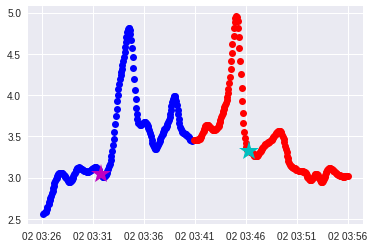

In [8]:
plt.plot_date( testDFPolewards["date"], testDFPolewards["filtEleFluxPoleArr"], 'bo' )
plt.plot_date( testDFEquatorwards["date"], testDFEquatorwards["filtEleFluxEquatorArr"], 'ro' )
plt.plot_date( polePassEqBndDF["date"], polePassEqBndDF["filtEleFluxPoleArr"], 'm*', markersize=20 )
plt.plot_date( equatorPassEqBndDF["date"], equatorPassEqBndDF["filtEleFluxEquatorArr"], 'c*', markersize=20 )

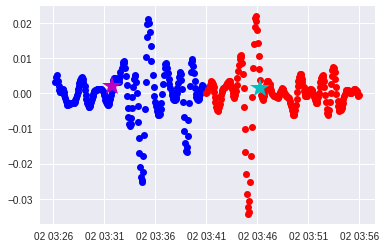

In [9]:
plt.plot_date( testDFPolewards["date"], testDFPolewards["diffEleFluxPoleArr"], 'bo' )
plt.plot_date( testDFEquatorwards["date"], testDFEquatorwards["diffEleFluxEquatorArr"], 'ro' )
plt.plot_date( polePassEqBndDF["date"], polePassEqBndDF["diffEleFluxPoleArr"], 'm*', markersize=20 )
plt.plot_date( equatorPassEqBndDF["date"], equatorPassEqBndDF["diffEleFluxEquatorArr"], 'c*', markersize=20 )